# **Pre-processing**

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.initializers import Constant
import tensorflow as tf
import jieba
import numpy as np
import pandas as pd
from tqdm import tqdm
tf.random.set_seed(42)

# **Preparing data**

In [ ]:
df = pd.read_csv(r'/your_data.csv',encoding='utf-8-sig' )
reviews = df['message'].values.tolist()
jieba.set_dictionary(r'/jieba_dict/dict.txt.big')


def stopwordslist(a):  
    stopwords = [line.strip() for line in open(a, 'r', encoding='utf-8-sig').readlines()]  
    return stopwords  

stopwords = stopwordslist(r'/jieba_dict/stopwords.txt') 

review_lines = list()

for review in tqdm(reviews):   
    ws = jieba.cut(review, cut_all=True) # accurate mode
    a=[]
    for w in ws:
        if w not in stopwords:
          a.append(w)
    review_lines.append(a)

# **Set up word2vec**

In [ ]:
# emotional vec

df_cvaw = pd.read_csv(r"/cvaw4.csv",encoding='utf-8-sig').drop(['No.'], axis=1)

embeddings_index_cvaw =  dict([(i,[a,b,c,d]) for i,a,b,c,d in zip(df_cvaw['Word'],
                  df_cvaw['Valence_Mean'],df_cvaw['Valence_SD'],df_cvaw['Arousal_Mean']
                  ,df_cvaw['Arousal_SD'])])
df_cvaw.head()

,Word,Valence_Mean,Valence_SD,Arousal_Mean,Arousal_SD,Frequency
0,不可思議,5.4,1.02,7.2,1.327,80
1,不平,3.6,0.49,5.8,0.980,65
2,不甘,3.2,0.40,6.4,0.800,31
3,不安,3.8,0.40,5.4,0.490,184
4,不利,3.6,0.49,5.6,0.800,158


In [ ]:
#wiki word2vec
embeddings_index = dict()
with open(r"/keras_word2vec.txt",encoding='utf-8-sig') as f:
  for line in f:
    values = line.split()
    if len(values) != 301:
      print(values)
      continue
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

['954661', '300']


In [ ]:
#target data word2vec
embeddings_index_beef = dict()
with open(r"/keras_beefsoup.txt",encoding='utf-8-sig') as f:
  for line in f:
    values = line.split()
    # only accept 301 embedding=>(word + 300d embedding)
    if len(values) != 301:
      print(values)
      continue
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index_beef[word] = coefs

['2027', '300']


In [ ]:
tokenizer_obj = tf.keras.preprocessing.text.Tokenizer()
tokenizer_obj.fit_on_texts(review_lines)
sequences = tokenizer_obj.texts_to_sequences(review_lines)
word_index = tokenizer_obj.word_index

#Zero Padding
review_pad = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=128)
review_pad_rev = np.array([np.flip(item) for item in review_pad])

sentiment =  df['status'].values

In [ ]:
#transform to emotional vec
vocab_size = len(word_index) + 1 
cvaw_matrix = np.zeros((vocab_size, 4))
for word, i in tokenizer_obj.word_index.items():
    embedding_vector = embeddings_index_cvaw.get(word)
    if embedding_vector is not None:
        cvaw_matrix[i] = embedding_vector

In [ ]:
#transform to wiki wordvec
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer_obj.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
#transform to target data wordvec
vocab_size = len(word_index) + 1 
embedding_matrix_beef = np.zeros((vocab_size, 300))
for word, i in tokenizer_obj.word_index.items():
    embedding_vector = embeddings_index_beef.get(word)
    if embedding_vector is not None:
        embedding_matrix_beef[i] = embedding_vector

# **Define model**

In [ ]:
NUM_CLASSES = 1 
MAX_NUM_WORDS = 10000  
MAX_SEQUENCE_LENGTH =128  
NUM_LSTM_UNITS = 128  

In [ ]:
top_input = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH, ),dtype='int32')
bm_input = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH, ),dtype='int32')


embedding_layer_w2v = tf.keras.layers.Embedding(vocab_size, 300, embeddings_initializer=Constant(embedding_matrix), trainable=False)
embedding_layer_tar = tf.keras.layers.Embedding(vocab_size, 300, embeddings_initializer=Constant(embedding_matrix_tar), trainable=False)
# embedding_layer_cvaw = tf.keras.layers.Embedding(vocab_size, 4, embeddings_initializer=Constant(cvaw_matrix), trainable=False)

top_embedded = embedding_layer_w2v(top_input)
bm_embedded = embedding_layer_w2v(top_input)
# bm_embedded = embedding_layer_tar(top_input)
# bm_embedded = embedding_layer_cvaw(bm_input)


shared_lstm = tf.keras.layers.lstm(NUM_LSTM_UNITS, dropout = 0.2, recurrent_dropout = 0.2)
shared_lstm2 = tf.keras.layers.lstm(NUM_LSTM_UNITS, dropout = 0.2, recurrent_dropout = 0.2)

top_output = shared_lstm(top_embedded)
bm_output = shared_lstm2(bm_embedded)

merged = tf.keras.layers.concatenate([top_output, bm_output],axis=-1)

dense =  tf.keras.layers.Dense(units=NUM_CLASSES,activation='sigmoid')
predictions = dense(merged)

model = tf.keras.Model(
    inputs=[top_input, bm_input], 
    outputs=predictions)

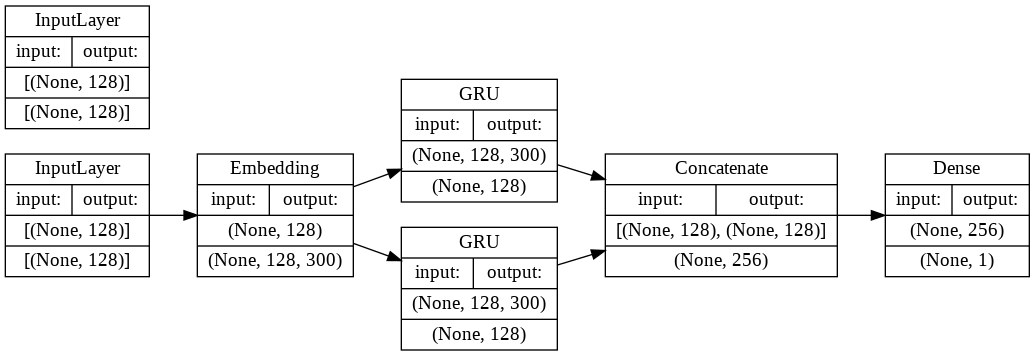

In [ ]:
tf.keras.utils.plot_model(
    model, 
    to_file='model.png', 
    show_shapes=True, 
    show_layer_names=False, 
    rankdir='LR')

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 128, 300)     2564400     ['input_5[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 gru_4 (GRU)                    (None, 128)          165120      ['embedding_4[0][0]']            
                                                                                                  
 gru_5 (GRU)                    (None, 128)          165120      ['embedding_4[1][0]']      

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

# **Example**

In [ ]:
history = model.fit(x=[review_pad,review_pad_rev],y=sentiment,batch_size=128,
                   epochs=10,validation_split=0.1,verbose=1
                   )

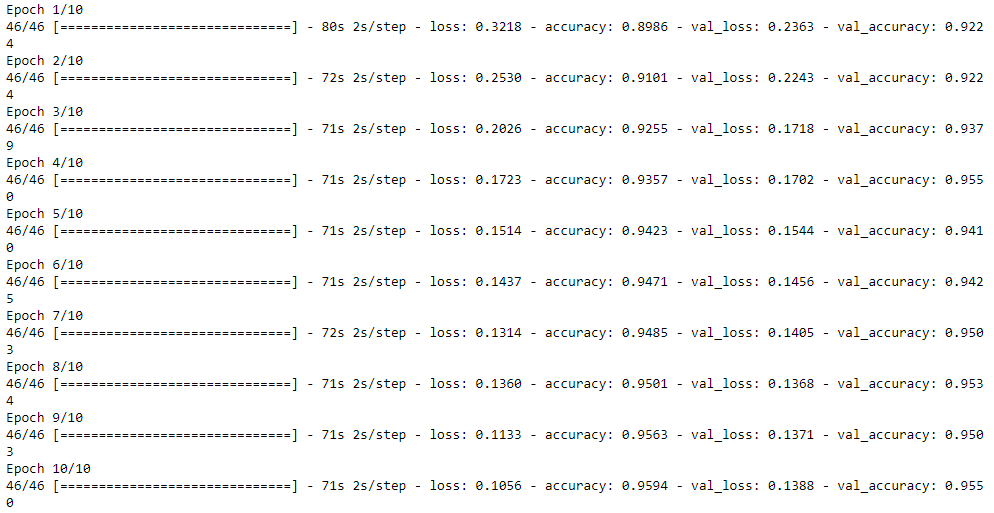

# **Classify data**

In [ ]:
df1 = pd.read_csv(r'/test_data.csv',encoding='utf-8-sig' )
reviews1 = df1['message'].values.tolist()

review_lines1 = list()

for review in tqdm(reviews1):   
    ws = jieba.cut(review, cut_all=True)
    a=[]
    for w in ws:
        if w not in stopwords:
          a.append(w)
    review_lines1.append(a)

q=['難吃']
qq = tokenizer_obj.texts_to_sequences(review_lines1)
qqq = tf.keras.preprocessing.sequence.pad_sequences(qq, maxlen=128)
qqq_rev = np.array([np.flip(item) for item in qqq])

sentiment1 =  df1['status'].values

model.evaluate([qqq,qqq_rev],sentiment1)

# **Training data sample**

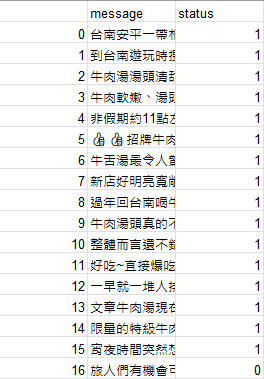

# **Test data sample**

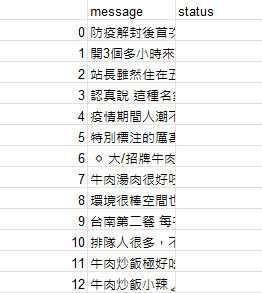